In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import linprog

#### Задаем параметры
<br>sigma - дисперсия шума при моделировании экспериментального сигнала
<br>a_original - истинные коэффиценты уравнения $y = a_2sin(t) + a_1t + a_0$. Хранятся в массиве в порядке $a_2, a_1, a_0$
<br>m - количество частей, на которые дробим отрезок
<br>t - вектор узлов сетки

In [2]:
sigma = 0.2
a_original = np.array([0.5, 0.1, 0.0])
m = 200.0
t = np.array([i*10.0/m for i in range(int(m))])

#### Вспомогательные функции
values - возвращает ряд значений функции  $y = a_2sin(t) + a_1t + a_0$ на узлах сетки t
<br>sum_of_array - возвращает сумму элементов массива, применяя к каждому функцию f

In [3]:
def values(a):
    # receives vector of parametres and raw of coordinates, returns raw of values
    return np.array([a[0]*np.sin(coordinate) + a[1]*coordinate + a[2] for coordinate in t])


def sum_of_array(f, X):
    # function returns sum of array elements with f implemented to them
    sum = 0
    for elem in X:
        sum += f(elem)
    return sum

#### Генерируем данные
y_original - истинные значения
<br>y_random - значения с Гауссовским шумом с дисперсией sigma 

In [4]:
y_original = values(a_original)
y_random = np.array([element + random.gauss(0, sigma) for element in y_original])

### Минимизируем сумму квадратов
Функция невязок имеет вид: $f(a) = \sum_{i=1}^n (y_i - a_2sin(t_i) - a_1t_i - a_0)^2$
<br>Продифференцируем ее и приравняем производную к нулю. Получим систему вида Ax = b, где
<t>A = $\begin{pmatrix}
\sum_{i=1}^nsin(t_i)^2 & \sum_{i=1}^nt_isin(t_i) & \sum_{i=1}^nsin(t_i) \\
\sum_{i=1}^nt_isin(t_i) & \sum_{i=1}^nt_i^2 & \sum_{i=1}^nt_i \\         
\sum_{i=1}^nsin(t_i) & \sum_{i=1}^nt_i & n
\end{pmatrix}$, 
 b =  $\begin{pmatrix}
\sum_{i=1}^ny_isin(t_i)\\
\sum_{i=1}^ny_it_i)\\         
\sum_{i=1}^ny_i
\end{pmatrix}$ 
<t>решение этой системы - вектор параметров a_est2


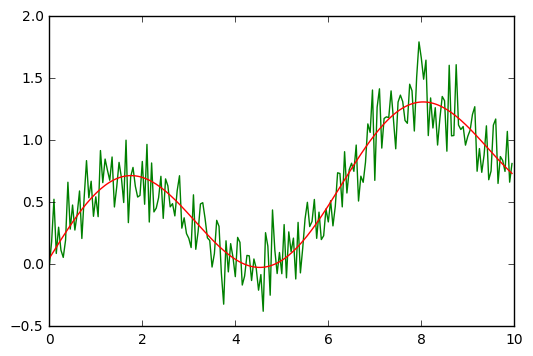

In [9]:
def get_est2():
    v1 = sum_of_array(lambda x: np.sin(x)**2, t)
    v2 = sum_of_array(lambda x: x*np.sin(x), t)
    v3 = sum_of_array(lambda x: np.sin(x), t)
    v4 = sum_of_array(lambda x: x**2, t)
    v5 = sum_of_array(lambda x: x, t)

    A = np.array([[v1, v2, v3],
                  [v2, v4, v5],
                  [v3, v5, m]])
    b = np.array([sum_of_array(lambda i: y_random[i] * np.sin(t[i]), range(int(m))),
                  sum_of_array(lambda i: y_random[i] * t[i], range(int(m))),
                  sum_of_array(lambda x: x, y_random)])
    return  np.linalg.solve(A, b)

a_est2 = get_est2()
y_est2 = values(a_est2)
plt.clf()
plt.plot(t, y_random, 'g')
plt.plot(t, y_est2, 'r')
plt.show()

### Минимизируем сумму модулей
Функция невязок имеет вид: $f(a) = \sum_{i=1}^n |y_i - a_2sin(t_i) - a_1t_i - a_0|$
<br>фомулируем эту задачу в виде задачи линейного программирования
<br> $min \sum_{i=1}^n \delta_i$
<br> $y_i - a_2sin(t_i) - a_1t_i - a_0 \leq \delta_i$
<br> $-y_i + a_2sin(t_i) + a_1t_i + a_0 \leq \delta_i$     <br> $\forall i \in \overline{1,n}$

<t> Параметры для старта симплекс-алгоритма
<br> $x = (a_2^+, a_2^-, a_1^+, a_1^-, a_0^+, a_0^-, \delta_1, ... , \delta_n)^T$, размерность n+6
<br> $c = (0, 0, 0, 0, 0, 0, 1, ..., 1)^T$, размерность n+6
<br> $b = (-y_1, y_1, ..., -y_i, y_i, ... , -y_n, y_n)^T$, размерность 2n
<br> $A = \begin{pmatrix}
-sin(t_1) & sin(t_1) & -t_1 & t_1 & -1 & 1 & -1 & \cdots & 0 & \cdots & 0 \\
sin(t_1) & -sin(t_1) & t_1 & -t_1 & 1 & -1 & -1 & \cdots & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & \vdots & 0 & \vdots & 0 \\
-sin(t_i) & sin(t_i) & -t_i & t_i & -1 & 1 & 0 & \cdots & -1 & \cdots & 0 \\
sin(t_i) & -sin(t_i) & t_i & -t_i & 1 & -1 & 0 & \cdots & -1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & \vdots & 0 & \vdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
-sin(t_n) & sin(t_n) & -t_n & t_n & -1 & 1 & 0 & \cdots & 0 & \cdots & -1 \\
sin(t_n) & -sin(t_n) & t_n & -t_n & 1 & -1 & 0 & \cdots & 0 & \cdots & -1 
\end{pmatrix}$, размерность (n+6)x2n

<t> $a_2 = a_2^+ - a_2^-, a_1 = a_1^+ - a_1^-, a_0 = a_0^+ - a_0^-$

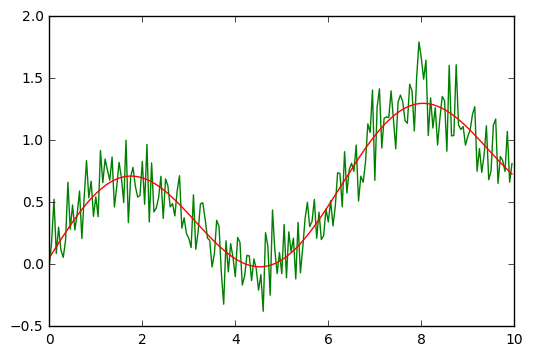

In [11]:
def get_est1():
    A = np.zeros([2*int(m), int(m) + 6])
    c = np.ones(int(m) + 6)
    b = np.zeros(2*int(m))
    for i in range(6):
        c[i] = 0.0


    for i in range(int(m)):
        b[2 * i] = -1*y_random[i]
        b[2 * i + 1] = y_random[i]

        A[2 * i][0] = -1*np.sin(t[i])
        A[2 * i][1] = np.sin(t[i])
        A[2 * i][2] = -1 * t[i]
        A[2 * i][3] = t[i]
        A[2 * i][4] = -1.0
        A[2 * i][5] = 1.0
        A[2 * i][i + 6] = -1.0

        A[2 * i + 1][0] = np.sin(t[i])
        A[2 * i + 1][1] = -1 * np.sin(t[i])
        A[2 * i + 1][2] = t[i]
        A[2 * i + 1][3] = -1 * t[i]
        A[2 * i + 1][4] = 1.0
        A[2 * i + 1][5] = -1.0
        A[2 * i + 1][i + 6] = -1.0


    optimized = linprog(c, A, b)
    if type(optimized.x) != float:
        return np.array([optimized.x[0] - optimized.x[1], optimized.x[2] - optimized.x[3], optimized.x[4] - optimized.x[5]])
    else:
        print optimized.message
        return np.zeros(3)
    
a_est1 = get_est1()
y_est1 = values(a_est1)
plt.clf()
plt.plot(t, y_random, 'g')
plt.plot(t, y_est1, 'r')
plt.show()

### Минимизируем максимальную невязку
Функция невязок имеет вид: $f(a) = max_{i \in \overline{1, n}} |y_i - a_2sin(t_i) - a_1t_i - a_0|$
<br> формулируем задачу в виде задачи линейного программирования
<br> $min \delta$
<br> $y_i - a_2sin(t_i) - a_1t_i - a_0 \leq \delta$
<br> $-y_i + a_2sin(t_i) + a_1t_i + a_0 \leq \delta$     <br> $\forall i \in \overline{1,n}$

<t> Параметры для старта симплекс-алгоритма
<br> $x = (a_2^+, a_2^-, a_1^+, a_1^-, a_0^+, a_0^-, \delta)^T$, размерность 7
<br> $c = (0, 0, 0, 0, 0, 0, 1)^T$, размерность 7
<br> $b = (-y_1, y_1, ..., -y_i, y_i, ... , -y_n, y_n)^T$, размерность 2n
<br> $A = \begin{pmatrix}
-sin(t_1) & sin(t_1) & -t_1 & t_1 & -1 & 1 & -1\\
sin(t_1) & -sin(t_1) & t_1 & -t_1 & 1 & -1 & -1\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & -1\\
-sin(t_i) & sin(t_i) & -t_i & t_i & -1 & 1 & -1 \\
sin(t_i) & -sin(t_i) & t_i & -t_i & 1 & -1 & -1 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & -1\\
\vdots & \vdots & \ddots & \vdots \\
-sin(t_n) & sin(t_n) & -t_n & t_n & -1 & 1 & -1 \\
sin(t_n) & -sin(t_n) & t_n & -t_n & 1 & -1 & -1  
\end{pmatrix}$, размерность (7)x2n

<t> $a_2 = a_2^+ - a_2^-, a_1 = a_1^+ - a_1^-, a_0 = a_0^+ - a_0^-$

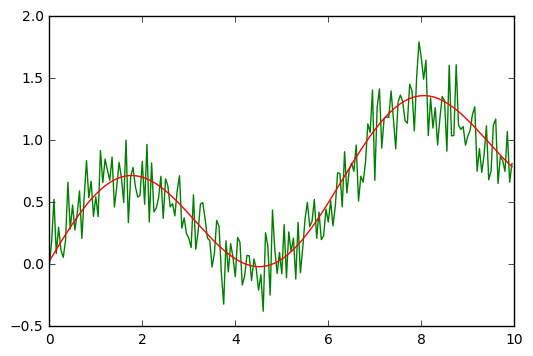

In [14]:
def get_est3():
    A = np.zeros([2*int(m), 7])
    c = np.zeros(7)
    b = np.zeros(2*int(m))
    c[6] = 0


    for i in range(int(m)):
        b[2 * i] = -1*y_random[i]
        b[2 * i + 1] = y_random[i]

        A[2 * i][0] = -1*np.sin(t[i])
        A[2 * i][1] = np.sin(t[i])
        A[2 * i][2] = -1 * t[i]
        A[2 * i][3] = t[i]
        A[2 * i][4] = -1.0
        A[2 * i][5] = 1.0
        A[2 * i][6] = -1.0

        A[2 * i + 1][0] = np.sin(t[i])
        A[2 * i + 1][1] = -1 * np.sin(t[i])
        A[2 * i + 1][2] = t[i]
        A[2 * i + 1][3] = -1 * t[i]
        A[2 * i + 1][4] = 1.0
        A[2 * i + 1][5] = -1.0
        A[2 * i + 1][6] = -1.0

    optimized = linprog(c, A, b)
    if type(optimized.x) != float:
        return np.array([optimized.x[0] - optimized.x[1], optimized.x[2] - optimized.x[3], optimized.x[4] - optimized.x[5]])
    else:
        print optimized.message
        return np.zeros(3)

a_est3 = get_est3()
y_est3 = values(a_est3)
plt.clf()
plt.plot(t, y_random, 'g')
plt.plot(t, y_est3, 'r')
plt.show()

### Строим графики в одной плоскости
зеленый - данные эксперимента
<br>красный - минимизация суммы квадратов
<br>желтый - минимизация суммы модулей
<br>фиолетовый - минимизация максимального модуля

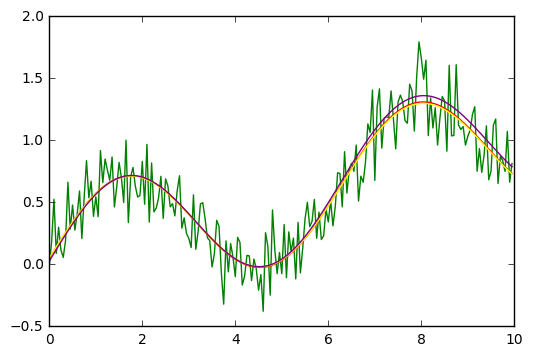

In [16]:
plt.clf()
plt.plot(t, y_random, 'g')
plt.plot(t, y_est2, 'r')
plt.plot(t, y_est1, 'yellow')
plt.plot(t, y_est3, 'purple')
plt.show()

### Определяем ошибки параметров
запустим все три алгоритма при разных sigma и посмотрим на отличия

In [21]:
N = 10
sigma_start = sigma
for i in range(N)[1:]:
    sigma = (i+1)*sigma_start*10/N
    y_random = np.array([element + random.gauss(0, sigma) for element in y_original])
    a_est1 = get_est1()
    a_est2 = get_est2()
    a_est3 = get_est3()
    print "\n sigma = " + str(sigma)
    print "summ of squares: " + str(a_est2) + ", difference: " + str(a_est2 - a_original)
    print "summ of modules: " + str(a_est1) + ", difference: " + str(a_est1 - a_original)
    print "max module: " + str(a_est3) + ", difference: " + str(a_est3 - a_original)
sigma = sigma_start


 sigma = 0.4
summ of squares: [ 0.49757323  0.10310639 -0.07494737], difference: [-0.00242677  0.00310639 -0.07494737]
summ of modules: [ 1.01397715  0.1887655  -0.46417221], difference: [ 0.51397715  0.0887655  -0.46417221]
max module: [ 0.33759896  0.14288383 -0.35838481], difference: [-0.16240104  0.04288383 -0.35838481]

 sigma = 0.6
summ of squares: [ 0.43803859  0.12295516 -0.08444645], difference: [-0.06196141  0.02295516 -0.08444645]
summ of modules: [ 1.25431218  0.39339062 -1.80366783], difference: [ 0.75431218  0.29339062 -1.80366783]
max module: [ 0.36000924  0.15950887 -0.24986512], difference: [-0.13999076  0.05950887 -0.24986512]

 sigma = 0.8
summ of squares: [ 0.45872412  0.10276259 -0.01683671], difference: [-0.04127588  0.00276259 -0.01683671]
summ of modules: [ 0.43329153  0.07345137  0.13386925], difference: [-0.06670847 -0.02654863  0.13386925]
max module: [ 0.92562662  0.12779825 -0.49969269], difference: [ 0.42562662  0.02779825 -0.49969269]

 sigma = 1.0
summ 

### Добавляем выбросы на границах
зеленый - данные эксперимента
<br>красный - минимизация суммы квадратов
<br>желтый - минимизация суммы модулей
<br>фиолетовый - минимизация максимального модуля
в крайней левой точке -15, в крайней правой +15

![disturbed_data](figure_1.png)